# Index
### A) Recursive GLS
    [A.1] Import Packages
    [A.2] Get Batch of Knots
    [A.3] Get Tau Forward and Tau Backward
    [A.4] Calculate Annihilator Terms
    [A.5] Calculate Kernel for Q and P Matrices
    [A.6] Calculate Kernels for Covariance Matrix
    [A.7] Calculate LHS
    [A.8] Calculate RHS
    [A.9] Calculate Q and P matrices
    [A.10] Covariance Matrix Calculation
    [A.11] Reconstruct yE(t)
    [A.12] Iterative Integration
    [A.13] Recursive Generalized Least Squares Auxiliary Equations
    [A.14] Recursive GLS


### B) 4th Order Linear System
    [B.2] Add White Gaussian Noise
    [B.3] 4th Order Homogeneus LTI System Modeling

### C) Run Algorithm
    [C.1] Model 4th Order System
    [C.2] Run Algorithm
    [C.3] Results   

## Recursive GLS
### Import Packages

In [1]:
#Import Relevant Packages
from scipy import interpolate
from scipy import integrate
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import time
import filterpy
import math
from scipy.linalg import expm
%matplotlib inline

### Get batch of knots

In [2]:
def get_batch(y, t, knots, iteration, mode, idx_describe=False):
    '''Function contains several strategies to select the knot points:
    Inputs: 
    - y: measured signal / true signal
    - t: time samples
    - knots: number of batch points (knots) required
    - mode: strategy to select the knots
        1) uniform: selects uniformly distributed knot points over the horizon
        2) midpoint: returns the midpoint of the horizon as single knot
        3) endpoint: returns the endpoint of the horizon as single knot
        4) three_knots: returns the start, mid and end point as 3 knot points
        5) random_end: returns knots from last 10% of the horizon/time samples
        6) random_start: returns knots from start 10% of the horizon/time samples
        7) random_middle: returns knots from middle 10% of the horizon/time samples
        8) random_middle_more: returns knots from middle 40% of the horizon/time samples
        9) random_more_at_middle: returns 60% knots from middle and 40% from remaining horizon/time samples
        10) random_more_at_ends: returns 60% knots from ends and 40% from remaining horizon/time samples
        11) random: returns randomly selected knots over the horizon
    - idx_describe: Returns the sample points selected for plotting
    '''
    
    np.random.seed(iteration)

    if mode == "uniform": 
        idx = np.arange(0, t.shape[0], int(t.shape[0]/knots))
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots

    elif mode == "midpoint":
        t_knots = np.array([t[t.shape[0]//2]])
        return t_knots

    elif mode == "endpoint":
        t_knots = np.array([t[-1]])
        return t_knots

    elif mode == "three_knots":
        t_knots = np.array([t[0],t[t.shape[0]//2],t[-1]])
        idx=np.array([0,t.shape[0]//2,t.shape[0]-1])
        if idx_describe==True:
            return t_knots,idx
        else:
            return t_knots

    elif mode == "random_end":
        t_shape = t.shape[0]//10
        idx = np.random.choice(t_shape, size=knots, replace=False)
        idx = np.sort(idx)
        idx = (t_shape*9) + idx
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots

    elif mode == "random_start":
        t_shape = t.shape[0]//10
        idx = np.random.choice(t_shape, size=knots, replace=False)
        idx = np.sort(idx)
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots        

    elif mode == "random_middle":
        t_shape = t.shape[0]//10
        #t_shape=int(t.shape[0]*0.3)
        idx = np.random.choice(t_shape, size=knots, replace=False)
        idx = np.sort(idx)
        idx= int(t_shape*4.5) + idx
        #idx= int(t.shape[0]*0.35) + idx
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots
        
    elif mode == "random_middle_more":
        #t_shape = t.shape[0]//10
        t_shape=int(t.shape[0]*0.4)
        idx = np.random.choice(t_shape, size=knots, replace=False)
        idx = np.sort(idx)
        #idx= int(t_shape*4.5) + idx
        idx= int(t.shape[0]*0.3) + idx
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots
    
    elif mode == "random_more_at_middle":
        t_shape=t.shape[0]//4
        idx = np.random.choice(len(t), size=int(knots*0.4), replace=False)
        idx_ = np.random.choice(t_shape, size=int(knots*0.6), replace=False)
        #idx_2=idx_
        idx_ = int(t_shape*1.5) + idx_
        idx=np.concatenate((idx, idx_), axis=0)
        idx = np.sort(idx)
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots
        
    elif mode == "random_more_at_ends":
        t_shape=t.shape[0]//5
        idx = np.random.choice(len(t), size=int(knots*0.4), replace=False)
        idx_ = np.random.choice(t_shape, size=int(knots*0.3), replace=False)
        idx_2=idx_
        idx_ = (t_shape*4) + idx_
        idx=np.concatenate((idx, idx_,idx_2), axis=0)
        idx = np.sort(idx)
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots
    
    elif mode == "random":
        idx = np.random.choice(len(t), size=knots, replace=False)
        idx = np.sort(idx)
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots
    
    elif mode== "mid_end_point":
        idx = int(t.shape[0]/2)
        idx2= t.shape[0]-1
        t_knots = np.array([t[idx], t[idx2]])
        return t_knots
        
    else:
        t_knots = np.array([])
        return t_knots

### Get Tau Forward and Tau Backward

In [3]:
def get_tau(y, t, ti, describe=False):
    '''Provides the time instants for the forward and backward kernel integration
    >>> get_tau(y, t, ti=3)
    >>> t.shape (10,)
            ti=  3
            tau_F=  [0.         0.66666667 1.33333333 2.         2.66666667]
            tau_B=  [3.33333333 4.         4.66666667 5.33333333 6.        ]
    '''

    F_indices = np.where(t <= ti)[0]
    B_indices = np.where(t > ti)[0]
    tau_F = t[F_indices]
    tau_B = t[B_indices]
    
    if describe == True:
        print('\nCalled get_tau function\n')
        print('t.shape', t.shape)
        print('time instant= ', ti)
        print('tau_F= ', tau_F)
        print('tau_B= ', tau_B)
    return tau_F, tau_B

### Calculate Annihilator Terms

In [4]:
def get_alpha_tau(ti, tau_F, tau_B, a, b, n, order, describe=False):
    '''Provides the multiplication of LHS elements i.e [(t-a)**4 X (t-s)**(n-1)]/(n-1)! for integration
    >>> get_alpha_tau(ti, tau_F, tau_B, a, b, n=1,describe=True)
    >>> ti=  3
            tau_F=  [0.         0.66666667 1.33333333 2.         2.66666667]
            tau_B=  [3.33333333 4.         4.66666667 5.33333333 6.        ]
            alpha_F=  [ 0.          0.19753086  3.16049383 16.         50.56790123]
            alpha_B=  [50.56790123 16.          3.16049383  0.19753086  0.        ]
            alpha_concatenated=  [ 0.          0.19753086  3.16049383 16.         50.56790123 50.56790123
             16.          3.16049383  0.19753086  0.        ]
    '''
    f = np.math.factorial
    
    # Calculate alpha forward
    delta_time_F = np.array((ti - tau_F)**(n-1))
    delta_tau_F = np.array((tau_F - a)**order) #changed
    alpha_F = np.multiply(delta_time_F, delta_tau_F)
    
    # Calculate alpha backward
    delta_time_B = np.array((ti - tau_B)**(n-1))
    delta_tau_B = np.array((b - tau_B)**order) #changed
    alpha_B = np.multiply(delta_time_B, delta_tau_B)

    alpha = np.concatenate((alpha_F, alpha_B), axis=0)
    alpha_ = np.array(alpha)

    if describe == True:
        print('\nCalled get_alpha_tau function\n')
        print('n (integral order)=', n)
        print('time instant= ', ti)
        print('tau_F= ', tau_F)
        print('tau_B= ', tau_B)
        print('alpha_F= ', alpha_F)
        print('alpha_B= ', alpha_B)
        print('alpha_concatenated= ', alpha)
        print('*'*10)

    return alpha_

### Calculate Kernels for Q and P Matrices

In [5]:
def get_KFn_vector(ti, tau_F, a, n, order):
    if tau_F.size == 1:
        tau_F = np.array([tau_F])
    N_tau = tau_F.shape[0]
    f = np.math.factorial
    gamma = np.zeros((order, N_tau))
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(tau_F - a)

    for i in range(0, order):
        gamma[i, :] = np.array((((ti - tau_F)**(n+i))*f(n-1))/(f(n+i)))
    #a=0.0
    for j in range(1, order+1):
        zeta[order,:]= zeta[order,:]+( ((-1)**(j+1)) * gamma[j-1, :] * ((delta**(order-j))/f(order-j))  * (f(order)/(f(j)*f(order-j))) * f(order))# *(np.ones(N_tau))) #const
    #print('outp ',zeta[order,:])
    #print('ti',ti)
    #print('tauF',tau_F)
    for i in range(0, order):    
        #zeta[i,:]=np.zeros(N_tau)
        if i==0:
            j=0
            zeta[i,:]= zeta[i,:]+(gamma[order-i+j-1, :] * ((delta**(order-j))/f(order-j)) * ((-1)**(j+1)) * (f(i)/(f(j)*f(i-j))) * f(order))
        else:
            for j in range(0, i+1):
                zeta[i,:]= zeta[i,:]+(gamma[order-i+j-1, :] * ((delta**(order-j))/f(order-j)) * ((-1)**(j+1)) * (f(i)/(f(j)*f(i-j))) * f(order))
        #print('outpu ',zeta[i,:])
    return zeta

In [6]:
def get_KBn_vector(ti, tau_B, b, n,order):
    if tau_B.size == 1:
        tau_B = np.array([tau_B])
    N_tau = tau_B.shape[0]
    f = np.math.factorial
    gamma = np.zeros((order, N_tau))
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(b - tau_B)

    for i in range(0, order):
        gamma[i, :] = np.array((((ti - tau_B)**(n+i))*f(n-1))/(f(n+i)))

    for j in range(1, order+1):
        zeta[order,:]= zeta[order,:]+(gamma[j-1, :] * ((delta**(order-j))/f(order-j)) * (f(order)/(f(j)*f(order-j))) * f(order))# *(np.ones(N_tau))) #const
    #print('outpB ',zeta[order,:])
    
    #print('ti',ti)
    #print('tauB',tau_B)   
    
    for i in range(0, order):    
        #zeta[i,:]=np.zeros(N_tau)
        if i==0:
            j=0
            zeta[i,:]=zeta[i,:]+ (gamma[order-i+j-1, :] * ((delta**(order-j))/f(order-j)) * (f(i)/(f(j)*f(i-j))) * f(order))
        else:
            for j in range(0, i+1):
                zeta[i,:]=zeta[i,:]+ (gamma[order-i+j-1, :] * ((delta**(order-j))/f(order-j)) * (f(i)/(f(j)*f(i-j))) * f(order))
        #print('outpuB ',zeta[i,:])
    if n > 0:
        zeta = np.array(-1.0*zeta)
    return zeta

### Calculate Kernels for S Matrix

In [7]:
def get_KDSn(ti, tau_F, tau_B, a, b, n, order, ak):
    beta = np.concatenate((ak, 1), axis=None)
    beta = beta.reshape(order+1, 1)

    KFn_vector = get_KFn_vector(ti, tau_F, a, n,order)
    KBn_vector = get_KBn_vector(ti, tau_B, b, n,order)
    KDSn_vector = np.concatenate((KFn_vector, KBn_vector), axis=1)

    KDSn = np.multiply(beta, KDSn_vector)
    KDSn = np.sum(KDSn, axis=0)
    return KDSn


def get_KFn(ti, tau_F, a, n, order, ak):
    beta = np.concatenate((ak, 1), axis=None)
    beta = beta.reshape(order+1, 1)

    KFn_vector = get_KFn_vector(ti, tau_F, a, n,order)
    KFn = np.multiply(beta, KFn_vector)
    KFn = np.sum(KFn, axis=0)
    return KFn


def get_KBn(ti, tau_B, b, n, order, ak):
    beta = np.concatenate((ak, 1), axis=None)
    beta = beta.reshape(order+1, 1)

    KBn_vector = get_KBn_vector(ti, tau_B, b, n,order)
    KBn = np.multiply(beta, KBn_vector)
    KBn = np.sum(KBn, axis=0)
    return KBn

### Calculate LHS

In [8]:
def get_LHS(y, t, tk, a, b, n, order, describe=False):
    f = np.math.factorial
    N = tk.shape[0]  # t_knots

    #print('\nstart time ',tk)
    if describe == True:
        print('\nCalculating get_LHS function\n')
        print('t_knots=', tk)

    LHS_n = np.zeros(N)
    r = 0
    for ti in tk:
        tau_F, tau_B = get_tau(y, t, ti)
        # Calculate alpha
        alpha = get_alpha_tau(ti, tau_F, tau_B, a, b, n, order, describe)
        # Calculate Integrand:
        integrand = np.multiply(alpha, y)
        # Integrate
        integral = np.trapz(integrand, t)
        # Store value
        LHS_n[r] = np.array((integral))
        r += 1
        
    return LHS_n

### Calculate RHS

In [9]:
def get_RHS(y, t, tk, a, b, n, order, describe=False):
    f = np.math.factorial
    N = tk.shape[0]
    #print('start time ',tk)
    RHS_n = np.zeros((N, order+1))
    r = 0
    for ti in tk:
        tau_F, tau_B = get_tau(y, t, ti)
        # Calculate Kernel vector
        KFn_vector = get_KFn_vector(ti, tau_F, a, n,order)
        KBn_vector = get_KBn_vector(ti, tau_B, b, n,order)
        KDSn_vector = np.concatenate((KFn_vector, KBn_vector), axis=1)

        if describe == True:
            print('\nCalculating get_RHS function\n')
            print('KFn=', KFn_vector)
            print(KFn_vector.shape)
            print('KBn=', KBn_vector)
            print(KBn_vector.shape)
            print('KDS=', KDSn_vector)
        # Calculate integrands
        integrand = np.multiply(KDSn_vector, y)
        # Integrate
        for k in range(0, order+1):
            RHS_n[r, k] = np.trapz(integrand[k, :], t)
        r += 1

    return RHS_n

### Calculate P and Q matrices

In [10]:
def get_P_Q(y, t, tk, a, b, order, n_min=1, n_max=5, describe=False, plot=False):
    f = np.math.factorial

    # n_min = 1#n_max-4
    n_vector = np.arange(n_min, n_max)

    for n in n_vector:
        #print('\n n= ', n)
        LHS_n = get_LHS(y, t, tk, a, b, n, order, describe)
        RHS_n = get_RHS(y, t, tk, a, b, n, order, describe)

        if n == n_vector[0]:
            LHS = np.array(LHS_n)
            RHS = np.array(RHS_n)
        else:
            LHS = np.concatenate((LHS, LHS_n), axis=None)
            RHS = np.vstack((RHS, RHS_n))

    # Arrange P:
    P = np.array(RHS[:, 0:order])
    # Arrange Q:
    Q = np.subtract(LHS, RHS[:, order])
    
#     print('\n')
    #print('\nCalculating get_PQ function\n')
    rank = np.linalg.matrix_rank(P)
#     print("\nRank of the Matrix P is : ", rank)
    #####determinant=np.linalg.det(P)
    #####print("\nDeterminant of the Matrix P is : ", determinant)
    #print('\nP shape= ',P.shape)
    #print('\nP= ',P)
    #print('\nQ shape=',Q.shape)
    #print('\nQ= ',Q)
    
    Pin = np.linalg.pinv(P)
    a_est = np.matmul(Pin, Q)
    
    if describe == True:
        print('\nParameter Estimates for individual eqns')
        for i in range(1, n_max-n_min+1):
            print('\nn= ', n_min-1+i)
            print('\nP=', P[knots*(i-1):knots*i])
            print('\nQ=', Q[knots*(i-1):knots*i])
            print('parameter=', np.matmul(np.linalg.pinv(
                P[knots*(i-1):knots*i]), Q[knots*(i-1):knots*i]))
            print('\na_est= ',a_est)
    
    if plot == True:
        plt.figure(figsize=(10, 7))
        for i in range(1, n_max-n_min+1):
            lab = 'Integration No.= '+str(n_min-1+i)
            plt.title('Error $(LHS-RHS)$')
            shape=a_est.shape[0]
            value=RHS[knots*(i-1):knots*i, shape]
            #print('val_co',value)
            for j in range(0,shape):
                value=value+RHS[knots*(i-1):knots*i, j]*a_est[j]
                #print('value',value)
            plt.plot(tk, LHS[knots*(i-1):knots*i]-value, label=lab)     
            #plt.plot(tk, LHS[knots*(i-1):knots*i]-(RHS[knots*(i-1):knots*i, 0]*a_est[0]+RHS[knots*(i-1):knots*i, 1]*a_est[1] +
           #                                        RHS[knots*(i-1):knots*i, 2]*a_est[2]+RHS[knots*(i-1):knots*i, 3]), label=lab)
            plt.xlabel('Time (sec)')
            plt.ylabel('LHS - RHS')
            plt.legend(loc='best')
            
        
        for i in range(1, n_max-n_min+1):
            plt.figure(figsize=(10, 7))
            lab = 'Integrating both LHS and RHS '+str(n_min-1+i)+' times'
            #ab = 'Integrating RHS '+str(n_min-1+i)+' times'
            plt.title(lab)
            shape=a_est.shape[0]
            value=RHS[knots*(i-1):knots*i, shape]
            for j in range(0, shape):
                value=value+RHS[knots*(i-1):knots*i, j]*a_est[j]
                
            plt.plot(tk, LHS[knots*(i-1):knots*i], label='LHS')
            plt.plot(tk, value, label='RHS')
            plt.xlabel('Time (sec)')
            plt.legend(loc='best')

    return P, Q

In [11]:
# Diagonal Covariance Matrix
def get_S(y, t, tk, a, b, order, ak,  n_min, n_max,var):
    #print(n_min,n_max)
    f = np.math.factorial

    N = tk.shape[0]

    n_vector = np.arange(n_min, n_max)  # n_max - 4

    S = np.zeros(((n_vector.shape[0])*N, (n_vector.shape[0])*N))

    m = 0
    for n in n_vector:
        Cov_inv = np.zeros((N, N))

        r1 = 0
        for ti in tk:
            tau_F, tau_B = get_tau(y, t, ti)

            KDSn = get_KDSn(ti, tau_F, tau_B, a, b, n, order, ak)
            #print('Kdsn',KDSn)
            alpha = get_alpha_tau(ti, tau_F, tau_B, a, b, n,order)
            integrand = np.array((alpha - KDSn)**2)

            Cov = np.array((var**2)*(np.trapz(integrand, t)))
            # np.linalg.inv(Cov) #np.array(1/Cov)-Shantanil
            Cov_inv[r1, r1] = np.array(1/Cov)
            # print('**r1**\n',r1)
           # print('***Cov***\n',Cov)
            # print('******\n\n')
            r1 += 1

        S[(m)*N: (m+1)*N, (m)*N: (m+1)*N] = np.array(Cov_inv)

        m += 1
    #print('\n***S (Diagonal_Covariance)***\n', S)
    #print('\nS shape= ',S.shape)
    #print('******\n\n')
    return S

# Full Covariance Matrix


def get_S1(y, t, tk, a, b, order,ak, n_min,n_max, var):
    f = np.math.factorial

    N = tk.shape[0]
    N_ext = t.shape[0]
    n_vector = np.arange(n_min, n_max)

    S = np.zeros(((n_vector.shape[0])*N, (n_vector.shape[0])*N))

    m = 0
    for n in n_vector:
        Cov = np.zeros((N, N))
        KDSn_tau = np.zeros((N, N_ext))
        alpha = np.zeros((N, N_ext))

        r1 = 0
        for ti in tk:
            tau_F, tau_B = get_tau(y, t, ti)

            KDSn_tau[r1, :] = get_KDSn(ti, tau_F, tau_B, a, b, n, order,ak)
            #print('Kdsn shape',KDSn_tau[r1, :])
            alpha[r1, :] = get_alpha_tau(ti, tau_F, tau_B, a, b, n,order)

            r1 += 1
        #print('Kdsn shape final',KDSn_tau)
        for r1 in range(0, N):
            for r2 in range(r1, N):
                # Get first term of the E(e^n*e^n)
                Cov1 = np.multiply(alpha[r1, :], alpha[r2, :])
                # Get second term of the E(e^n*e^n)
                Cov2 = np.multiply(alpha[r1, :], KDSn_tau[r2, :])
                # Get third term of the E(e^n*e^n)
                Cov3 = np.multiply(alpha[r2, :], KDSn_tau[r1, :])
                # Get fourth term of the E(e^n*e^n)
                Cov4 = np.multiply(KDSn_tau[r1, :], KDSn_tau[r2, :])

                # Since all of these terms have the same differential, they can be integrated all together.
                integrand = np.array((var**2)*(Cov1 - Cov2 - Cov3 + Cov4))

                Cov[r1, r2] = np.trapz(integrand, t)

                # Setup symmetry
                Cov[r2, r1] = np.array(Cov[r1, r2])

        # Concatenate results:
        S[(m)*N: (m+1)*N, (m)*N: (m+1)*N] = np.linalg.inv(Cov)
        m += 1

    return S

### Reconstruct yE(t)

In [12]:
def calculate_e(system_model, a_array, time_array):
    shape=a_array.shape[0]
    arr=np.zeros(shape)
    #print(arr)
    arr[0]=1.0
    rotate=list(arr)
    #print('arr', arr)
    
    y0=np.zeros((shape,shape))
    u=np.zeros((time_array.shape[0],shape))
    v=np.zeros((time_array.shape[0],shape))
    norm_v=np.zeros((shape,1))
    #print('y0',y0.shape)
    for  i in range(0,shape):
        y0[i] = arr
        u_sol =  integrate.odeint(system_model, y0[i], time_array, args=(a_array,))
        u[:,i]=u_sol[:,0]
        #print('u_sol',u_sol)
        #print('u',u)
        rotate= rotate[shape-1:]+rotate[:shape-1]
        arr=np.array(rotate)
        if i == 0:
            v[:,i]=u[:,i]
            norm_v[i]=np.linalg.norm(v[:,i], 2)
            #print('norm_v1',norm_v[i])
        else:
            sub=0
            for j in range(0,i):
                sub=sub+(( np.dot(u[:,i], v[:,j])/(norm_v[j]**2)) * v[:,j])
            v[:,i]=u[:,i]- sub
            norm_v[i]=np.linalg.norm(v[:,i], 2)
            #print('norm_v',norm_v[i])
    e=np.zeros((time_array.shape[0],shape))
    for k in range(0, shape):
        e[:,k]=v[:,k]/norm_v[k]
    #print('e',e)
    
    #e1 = v1/norm_v1
    #e2 = v2/norm_v2
    #e3 = v3/norm_v3
    
    return tuple(e.T)

def gen_nth_order_LTI_sys(y, t, a_array):
    #a0, a1, a2 = a_array[0], a_array[1], a_array[2]
    #y1, y2, y3 = y[0], y[1], y[2]
    last=0
    
    for i in range(0,a_array.shape[0]):
        last=last-a_array[i]*y[i]
    #print('y',y)
    #print(type(y))
    #print(lis)
    arr=list(y)
    arr.append(last)
    y_dot=arr[1:]
    
    #y_dot = [y2,
    #         y3,
    #         - a0*y1 - a1*y2 - a2*y3]
    return y_dot

### RLS with Identifiable Point Search

In [13]:
def initial_Rk(P, S):
    # Calculate initial Rk
    PT = np.transpose(P)
    PTS = np.matmul(PT, S)
    Mk1 = np.matmul(PTS, P)
    Rk = np.linalg.inv(Mk1)
    return Rk


def get_Rk1(P, S, Rk):
    # Calculate r_1 = (S^-1 + P*Rk*PT)^-1
    PT = np.transpose(P)
    S_inv = np.linalg.inv(S)
    RPT = np.matmul(Rk, PT)
    PRPT = np.matmul(P, RPT)
    r_1 = np.add(S_inv, PRPT)
    r_1 = np.linalg.inv(r_1)

    # Calculate r_2 = Rk*PT*r_1 =Rk*PT*(S^-1 + P*Rk*PT)^-1
    r_2 = np.matmul(RPT, r_1)

    # Calculate r_3 = r_2*P*Rk =Rk*PT*(S^-1 + P*Rk*PT)^-1*P*Rk
    PR = np.matmul(P, Rk)
    r_3 = np.matmul(r_2, PR)

    # Calculate Rk1
    Rk1 = np.subtract(Rk, r_3)

    return Rk1


def get_ak1(Q, P, S, ak, Rk1):
    # Calculate a_1 = (Q - P*ak)
    Pa = np.matmul(P, ak)
    a_1 = np.subtract(Q, Pa)

    # Calculate a_2 = Rk1*PT*S
    PT = np.transpose(P)
    PTS = np.matmul(PT, S)
    a_2 = np.matmul(Rk1, PTS)

    # Calculate a_3 = a_2*a_1 = Rk1*PT*S*(Q - P*ak)
    a_3 = np.matmul(a_2, a_1)

    # Calculate ak1
    ak1 = np.add(ak, a_3)

    return ak1

In [14]:
def RLS(y, t, a, b, knots, mode, ak, tol, order, n_min=1, n_max=5, var=1,iteration=0,max_iter=50):
    # Set initial iteration
    #iteration = 0
    eps = np.inf
    iteration_start=iteration
    # Define Time Points:
    t_knots = get_batch(y, t, knots, iteration, mode)
    #print('\n t_knots= ', t_knots)

    if t_knots.size == 0:
        print("WARNING! ALGORITHM STOPPED: Mode name incorrectly specified")
        ak, ak_log = None, None
        return ak, ak_log

    # Set initial conditions
    ak = np.zeros((order))

    # Store parameter estimation per iteration
    ak_log = np.array(ak)

#     print(iteration, ak)

    while tol < eps:

        # Get knots used in current iteration
        # get_tk(t_knots, iteration, mode)
        tk = get_batch(y, t, knots, iteration, mode)
        #print('\n tk= ', tk)
        P, Q = get_P_Q(y, t, tk, a, b, order, n_min, n_max, plot=False)

        # Calculate S matrix
        e = calculate_e(gen_nth_order_LTI_sys, ak, t) 
        yE=np.zeros((t.shape[0],1))
        arra=np.dot(y,e[0])
        for k in range(1,order):
            arra= np.append(arra,np.dot(y,e[k]))
        #print(arra)
        yE=np.dot(arra,e)#get_yE(y, t, ak)
        var = np.var(y - yE) #Variance Calculation
#         print('Var',var)

        #print(n_min,n_max,var)
        S = get_S(y, t, tk, a, b, order, ak, n_min, n_max, var)
        #S = np.identity(P.shape[0])

        if iteration == iteration_start:
            Rk = initial_Rk(P, S)
        else:
            Rk = get_Rk1(P, S, Rk)

        ak1 = get_ak1(Q, P, S, ak, Rk)

        eps = np.linalg.norm(ak1 - ak, np.inf)

        # Set next iteration
        iteration += 1
        ak = np.array(ak1)

        # Store parameter estimation per iteration
        ak_log = np.vstack((ak_log, ak))
        print(iteration, ak)

        # Max iteration:
        if iteration == max_iter +iteration_start:#knots*2:
            return ak, ak_log

    return ak, ak_log

## Derivative Reconstruction

In [15]:
def get_KFn_1_vector(ti, tau_F, a, order, derivative):
    if tau_F.size == 1:
        tau_F = np.array([tau_F])
    N_tau = tau_F.shape[0]
    f = np.math.factorial
    gamma = np.zeros((order-1, N_tau))
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(tau_F - a)
    n = order
    k = derivative
    p = n-k
    for i in range(0, order-1):
        gamma[i, :] = np.array(((ti - tau_F)**(i))/(f(i)))
        # print('gamma',gamma)
    # a=0.0
    for j in range(1, p+1):
        zeta[order, :] = zeta[order, :]+(((-1)**(j+n-p+1)) * gamma[j-1, :] * ((delta**(p-j))/f(
            p-j)) * (f(order)/(f(n-p+j)*f(order-n+p-j))) * f(order))  # *(np.ones(N_tau))) #const
    #print('outp ',zeta[order,:])
    # print('ti',ti)
    # print('tauF',tau_F)
    for i in range(0, p):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :]+(gamma[p-i+j-1, :] * ((delta**(n-j))/f(n-j))
                                     * ((-1)**(j+1)) * (f(i)/(f(j)*f(i-j))) * f(order))
        else:
            for j in range(0, i+1):
                zeta[i, :] = zeta[i, :]+(gamma[p-i+j-1, :] * ((delta**(n-j))/f(n-j)) * (
                    (-1)**(j+1)) * (f(i)/(f(j)*f(i-j))) * f(order))

    for i in range(p, n):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :]+(gamma[j-1, :] * ((delta**(n-j+p-i))/f(n-j+p-i)) * (
                (-1)**(j+i-p+1)) * (f(i)/(f(i-p+j)*f(p-j))) * f(order))
        else:
            for j in range(1,p+1):#(0,i+1):#(1, p+1):
                #print('i',i)
                #print('j',j)
                #print('p',p)
                #print('n',n)

                zeta[i, :] = zeta[i, :]+(gamma[j-1, :] * ((delta**(n-j+p-i))/f(n-j+p-i)) * (
                    (-1)**(j+i-p+1)) * (f(i)/(f(i-p+j)*f(p-j))) * f(order))
                #print(zeta[i,:])
    return zeta

In [16]:
def get_KBn_1_vector(ti, tau_B, b, order, derivative):
    if tau_B.size == 1:
        tau_B = np.array([tau_B])
    N_tau = tau_B.shape[0]
    f = np.math.factorial
    gamma = np.zeros((order-1, N_tau))
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(b - tau_B)
    n = order
    k = derivative
    p = n-k
    for i in range(0, order-1):
        gamma[i, :] = np.array(((ti - tau_B)**(i))/(f(i)))
    # a=0.0
    for j in range(1, p+1):
        zeta[order, :] = zeta[order, :]+(gamma[j-1, :] * ((delta**(p-j))/f(p-j)) * (
            f(order)/(f(n-p+j)*f(order-n+p-j))) * f(order))  # *(np.ones(N_tau))) #const
    #print('outpB ',zeta[order,:])
    # print('ti',ti)
    # print('tauF',tau_F)
    for i in range(0, p):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :]+(gamma[p-i+j-1, :] *
                                     ((delta**(n-j))/f(n-j)) * (f(i)/(f(j)*f(i-j))) * f(order))
        else:
            for j in range(0, i+1):
                zeta[i, :] = zeta[i, :]+(gamma[p-i+j-1, :] * (
                    (delta**(n-j))/f(n-j)) * (f(i)/(f(j)*f(i-j))) * f(order))

    for i in range(p, n):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :]+(gamma[j-1, :] * ((delta**(n-j+p-i)) /
                                                      f(n-j+p-i)) * (f(i)/(f(i-p+j)*f(p-j))) * f(order))
        else:
            for j in range(1,p+1):#(0,i+1):#(1, p+1):
                zeta[i, :] = zeta[i, :]+(gamma[j-1, :] * (
                    (delta**(n-j+p-i))/f(n-j+p-i)) * (f(i)/(f(i-p+j)*f(p-j))) * f(order))
    return zeta

In [17]:
def get_y_derivative(y, t, a, b, ak, order, derivative):
    f = np.math.factorial
    N = t.shape[0]
    RHS_n = np.zeros((N, order+1))
    beta = np.concatenate((ak, 1), axis=None)
    beta = beta.reshape(order+1, 1)
    r = 0
    for ti in t:
        #print(ti)
        #for i in range(1,11):
#         if ti==t[int(t.shape[0]*(2.5/10))]:
#             print('25% done')
#         elif ti==t[int(t.shape[0]*(5/10))]:
#             print('50% done')
#         elif ti==t[int(t.shape[0]*(7.5/10))]:
#             print('75% done')
#         elif ti==t[int(t.shape[0]*(9.9/10))]:
#             print('99% done')
        
        tau_F, tau_B = get_tau(y, t, ti)
        # Calculate Kernel vector
        # alpha = get_alpha_tau(ti, tau_F, tau_B, a, b, n=1) #(t-a)**4+(b-t)**4
        KFn_vector = get_KFn_1_vector(ti, tau_F, a, order, derivative)
        KBn_vector = get_KBn_1_vector(ti, tau_B, b, order, derivative)
        KDSn_vector = np.concatenate((KFn_vector, KBn_vector), axis=1)
        # Calculate integrands
        integrand = np.multiply(KDSn_vector, y)
        # print(integrand)
        # print('*'*10)
        integrand = np.multiply(beta, integrand)

        # Integrate
        for k in range(0, order+1):
            RHS_n[r, k] = np.trapz(integrand[k, :], t)
        r += 1
        KDSn = np.sum(RHS_n, axis=1)
        # print('shape',RHS_n.shape)
    return KDSn  # RHS_n

In [18]:
def get_KF_vector(y_all, ti, a, ak, order, derivative):
    N_tau = ti.shape[0]
    f = np.math.factorial
    beta = np.concatenate((ak, 1), axis=None)
    beta = beta.reshape(order+1, 1)
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(ti - a)
    n = order
    k = derivative
    p = n-k

    for i in range(1, k+1):
        zeta[order, :] = zeta[order, :]+(((-1)**(i+1)) * ((delta**(n-i))/f(n-i)) * (
            f(p+i-1)/(f(i)*f(p-1))) * f(n) * y_all[:, k-i])   # *(np.ones(N_tau))) #const
        '''print('y_est', y_all[:, k-i])
        print('delta power',n-i)
        print('ti-a', delta**(n-i))
        print('const', (((-1)**(i+1))/f(n-i)) * (
                    f(p+i-1)/(f(i)*f(p-1))) * f(n))
        print('outp ', zeta[order, :])
        print('i',i)
    print(order)'''

    # print('ti',ti)
    # print('tauB',tau_B)

    for i in range(p, order):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :] + (((-1)**(j+1)) * ((delta**(n-j))/f(n-j))
                                       * (f(p+j-1)/(f(j)*f(p-1))) * f(n) * y_all[:, i-j-p])
        else:
            for j in range(0, i-p+1):
                zeta[i, :] = zeta[i, :] + (((-1)**(j+1)) * ((delta**(n-j))/f(n-j)) * (
                    f(p+j-1)/(f(j)*f(p-1))) * f(n) * y_all[:, i-j-p])  # p=3,i=3,j=0
            '''print('y_est', y_all[:, i-j-p])
            print('delta power',n-j)
            print('ti-a', delta**(n-j))
            print('const', (((-1)**(j+1))/f(n-j)) * (
                    f(p+j-1)/(f(j)*f(p-1))) * f(n))
            print('outp ', zeta[i, :])
            print('order',i)
                #print('y_est', y_all[:, i-j-p])
                #print('ti-a', delta**(n-j))
                #print('const', (((-1)**(j))/f(n-j)) * (
                 #   f(p+j-1)/(f(j)*f(p-1))) * f(n))
        print('outpu ', zeta[i, :])
        print(i)'''
    #print('beta', beta)
    ans = np.multiply(beta, zeta)
    return ans

In [19]:
def get_KB_vector(y_all, ti, b, ak, order, derivative):
    N_tau = ti.shape[0]
    f = np.math.factorial
    #gamma = np.zeros((order, N_tau))
    beta = np.concatenate((ak, 1), axis=None)
    beta = beta.reshape(order+1, 1)
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(b - ti)
    n = order
    k = derivative
    p = n-k
    # for i in range(0, order):
    #    gamma[i, :] = np.array(((ti - tau_B)**(n+i))/(f(n+i)))

    for i in range(1, k+1):
        zeta[order, :] = zeta[order, :]+(((delta**(n-i))/f(n-i)) * (
            f(p+i-1)/(f(i)*f(p-1))) * f(n) * y_all[:, k-i])   # *(np.ones(N_tau))) #const
        '''print('y_est', y_all[:, k-i])
        print('delta power',n-i)
        print('ti-a', delta**(n-i))
        print('const', (1/f(n-i)) * (
                    f(p+i-1)/(f(i)*f(p-1))) * f(n))
        print('outp ', zeta[order, :])
        print('i',i)
    #print('outpB ', zeta[order, :])
    print(order)'''

    # print('ti',ti)
    # print('tauB',tau_B)

    for i in range(p, order):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :] + (((delta**(n-j))/f(n-j))
                                       * (f(p+j-1)/(f(j)*f(p-1))) * f(n) * y_all[:, i-j-p])
        else:
            for j in range(0, i-p+1):
                zeta[i, :] = zeta[i, :] + (((delta**(n-j))/f(n-j))
                                           * (f(p+j-1)/(f(j)*f(p-1))) * f(n) * y_all[:, i-j-p])
            '''print('y_est', y_all[:, i-j-p])
            print('delta power',n-j)
            print('ti-a', delta**(n-j))
            print('const', (1/f(n-j)) * (
                    f(p+j-1)/(f(j)*f(p-1))) * f(n))
            print('outp ', zeta[i, :])
            print('order',i)
        #print('outpuB ', zeta[i, :])
        print(i)'''
    ans = -np.multiply(beta, zeta)
    return ans

## 4th Order Linear System
### Add White Gaussian Noise

In [20]:
def add_AWGN(y, t, std,iteration=0):
    np.random.seed(iteration)
    #mu = np.inf
    #while 0.001 < mu:
    N = t.shape[0]
    noise = np.random.normal(0, std, size=N)
    #mu = np.abs(np.mean(noise))
    yM = np.array(y + noise)
    return yM

### System Definition

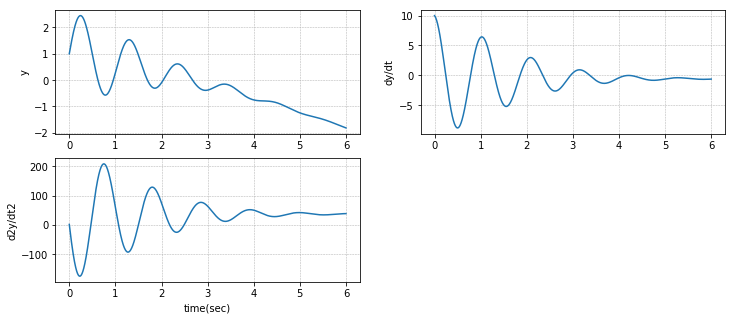

In [21]:
# 3rd order non-linear (initialize system's parameters)
R = 2 # Ohm
L = 400*10e-3 # Henri
k = 100 # Nm/A
r = 0.75#0.5 # m
m = 500 # kg
g = 9.81 # m/s^2

T_r = 3

def R_nonlinear(t):
    return R + 8*(1 - np.exp(-t/T_r))

# this one could be any other function of time
def u_t(t):
    return 0#t**2

def f(x, t):
    dx_dt = [0, 0, 0]
    dx_dt[0] = x[1]
    dx_dt[1] = (k/(r*m))*x[2]-g
    dx_dt[2] = -(R_nonlinear(t)/L)*x[2] - (k/r)*x[1] + (1/L)*u_t(t)
    return dx_dt

knots = 1
a = 0
b = 6#2
t = np.linspace(a, b, 60000) 
x0 = [1.0, 10.0, 1.0]
# x0 = [0.0, 5.0, 0.0]
xsol = odeint(f,x0,t)
y = xsol[:, 0]
ydot = xsol[:, 1]
ydotdot = xsol[:, 2]
plt.figure(figsize=(12,5))
plt.subplot(221)
plt.plot(t,y)
plt.ylabel('y')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.subplot(222)
plt.plot(t,ydot)
plt.ylabel('dy/dt')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.subplot(223)
plt.plot(t,ydotdot)
plt.xlabel('time(sec)')
plt.ylabel('d2y/dt2')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

## Run Algorithm

### Add Noise

mean =  -0.0002289132206246244
variance =  0.009941872207737052
std dev =  0.09970893745165
SNR_dB=  20.303460310202766
SNR=  107.23733954577818


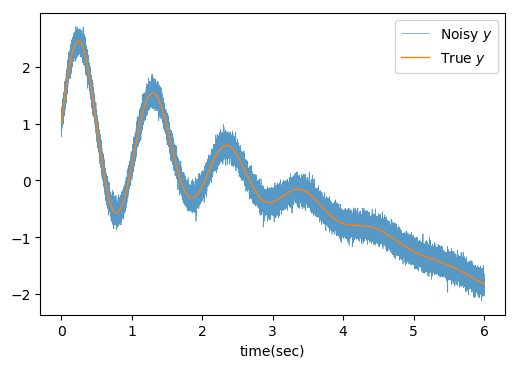

In [22]:
iteration = 0
#y=np.asarray((yE_new))
#t=np.asarray((t_new_))
std=0.1
ynoise = add_AWGN(y, t, std,iteration)
#Verify noise is white
print("mean = ", np.mean(ynoise - y))
print("variance = ", np.var(ynoise - y))
print("std dev = ", np.std(ynoise - y))
signal_power = np.mean(np.square(y))
noise_power = np.mean(np.square(y - ynoise))
SNR = signal_power/noise_power
SNR_dB = 10*np.log10(SNR)
print('SNR_dB= ', SNR_dB)
print('SNR= ', SNR)

#plt.figure(figsize=(15, 8))
plt.figure(dpi=100)
plt.plot(t, ynoise, lw=0.5,alpha=0.75,label="Noisy $y$")
plt.plot(t, y, lw=1,label="True $y$")
plt.xlabel('time(sec)')
plt.legend(loc='best')
#plt.savefig('C:/Users/admin/Desktop/Noisy_y_1_LPV.pdf')
plt.show()

### Adaptive Order Sliding Window Estimation

In [23]:
def prediction_fn(a_est, del_t):
    A = np.eye(3, k=1)
    A[2,0] = -a_est[0] 
    A[2,1] = -a_est[1] 
    A[2,2] = -a_est[2]
    return expm(A*del_t)

def prediction_fn2(a_est, del_t):
    A = np.eye(3, k=1)
    A[2,0] = -a_est[0] 
    A[2,1] = -a_est[1] 
    A[2,2] = -a_est[2]
    return (np.eye(3) + A * del_t)

    

# NEW TRIAL :

t_window size: 30000
start 0
stop 3
1 [19.99893246 22.56500425 -1.22409802]
2 [21.14524073 24.99437715 -0.9378372 ]
3 [21.77409189 26.36968436 -0.75537027]
4 [22.17767913 27.26099446 -0.63369255]
5 [22.45478161 27.87584802 -0.54871546]
6 [22.65392184 28.31884157 -0.48708855]
7 [22.80224417 28.64925227 -0.44094776]
8 [22.91603057 28.9029122  -0.40544307]
9 [23.00552826 29.10248578 -0.37746982]
10 [23.0774369  29.26284131 -0.35497543]
P_n is  [[ 1.10957563e-03  9.32260760e-05 -1.14681877e-04]
 [ 9.32260760e-05  1.06382945e-03 -3.39758616e-04]
 [-1.14681877e-04 -3.39758616e-04  6.07930781e-04]]
Skipping first update


IndexError: too many indices for array

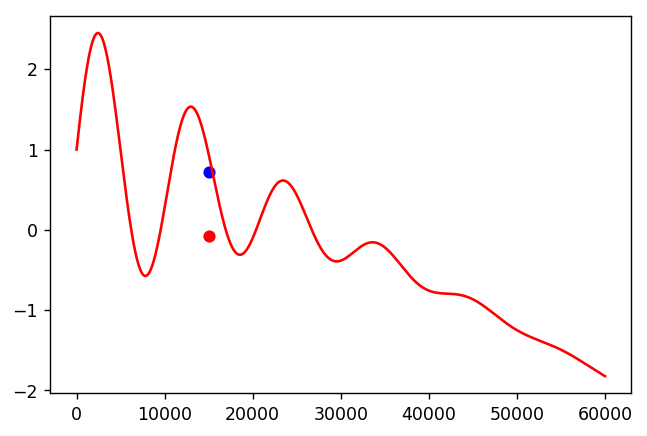

In [24]:
%%time

t_=t*(t.shape[0]//(b-a))

n_min=1
# order=3
n_max = 4
order1=3
knots = 50
mode = 'three_knots'
# mode = 'random'
tol = 0.1
window_size=3
window_shift=0.1
end = b-window_shift
#4,2 used for 5th order

#for logging
ltv_a=[]
t_mid_log = []
t_predict_log=[]
y_predict_log=[]
P_predict_log = []
z_log = []
X_log = []

yM=ynoise
#initialize
start=0#a=0
stop=start+window_size#b = a + window_size
ak1 = np.array([1.0, 5.0, 5.0])
aklog2=np.zeros((order1))
plt.figure(dpi=125)
plt.plot(t_,y,'r')

P_n = np.eye(3) * 0.001 
Q_n = 0.0001 * np.eye(3)
H_n = np.array([[1, 0, 0]])
X_n = np.array([-0.1,0.2,0.1]).T
R_n = np.array([[0.0001]])

y_predict_log.append(X_n)
t_predict_log.append(2000)
P_predict_log.append(P_n)
ye_log = np.zeros_like(t_)

ltv_a.append([1,5,5])
X_log.append(X_n)
z_log.append(0)


while(stop <= end):        
    stop = start + window_size    
    
    #this part is to section the signal into smaller horizons
    t_window = np.where((t>=start) & (t<=stop))[0]
    print("t_window size:",t_window.size)
    print('start',start)
    print('stop',stop)
    t_new = np.linspace(start,stop,t_window.size)
    yM_window = np.take_along_axis(yM, t_window, 0)
    
    #This is to use the previous estimate as an initial condition to the next one
    ak_init=ak1
    ak1, aklog1 = RLS(yM_window, t_new, start, stop, knots, mode, ak_init, tol, order1,n_min,n_max,var=std,max_iter=10)
    e = calculate_e(gen_nth_order_LTI_sys, ak1, t_new) #get_yE(yM_window, t_new, ak1)
    arra=np.dot(yM_window,e[0])
    for k in range(1,order1):#1,order
        arra= np.append(arra,np.dot(yM_window,e[k]))
    yE_1=np.dot(arra,e)

    
    
    #calculation of first derivative
    derivative = 1
    y_all = np.zeros((yM_window.shape[0], order1))
    y_all[:, 0] =  yE_1
    y_n = yE_1
    y_dot_est_F_int = np.zeros_like(y_n)
    y_dot_est_B_int = np.zeros_like(y_n)
    y_dot_est = np.zeros_like(y_n)
    out = get_y_derivative(yE_1, t_new, start, stop, ak1, order1, derivative)
    y_dot_est_F_int = get_KF_vector(y_all, t_new, start, ak1, order1, derivative)
    y_dot_est_B_int = get_KB_vector(y_all, t_new, stop, ak1, order1, derivative)
    y_dot_est_KD = np.sum(y_dot_est_F_int+y_dot_est_B_int, axis=0)
    y_dot_est = (y_dot_est_KD + out) / \
    (((t_new-start)**order1)+((stop-t_new)**order1))
    
   

#     #calculating second derivative - Kernel
    if order1>2:
        derivative1=2
        y_all[:,1] = y_dot_est
        y_ddot_est_F_int = np.zeros_like(y_n)
        y_ddot_est_B_int = np.zeros_like(y_n)
        y_ddot_est = np.zeros_like(y_n)
        out_d = get_y_derivative(yE_1, t_new, start, stop, ak1, order1, derivative1)
        y_ddot_est_F_int = get_KF_vector(y_all, t_new, start, ak1, order1, derivative1)
        y_ddot_est_B_int = get_KB_vector(y_all, t_new, stop, ak1, order1, derivative1)
        y_ddot_est_KD = np.sum(y_ddot_est_F_int+y_ddot_est_B_int, axis=0)
        y_ddot_est = (y_ddot_est_KD + out_d) / \
            (((t_new-start)**order1)+((stop-t_new)**order1))
               
        
        
    if order1==2:
        dy2 = np.zeros(len(dy1),np.float)
        dy2[0:-1] = np.diff(dy1)/np.diff(t_new)
        dy2[-1] = (dy1[-1] - dy1[-2])/(t_new[-1] - t_new[-2]) 
    
    
    ############## prediction for next iteration from previous params ######
    mid_idx = int(t_window.shape[0]/2)
    ###measurement for current window
    Z_n = yE_1[mid_idx] 
    plt.scatter(t_window[mid_idx],Z_n, color='blue', label='measurement')
    ###F_(N-1) ####
    F_n = prediction_fn(ltv_a[-1], window_shift)
    
    X_n = F_n@ X_n

    P_n = (F_n @ P_n @ F_n.T) + Q_n
    print("P_n is ", P_n)
    plt.scatter( t_window[mid_idx], X_n[0], color='red',label ='predict')    
        
    if (start==0):
        print("Skipping first update")
    
    else:
        ############################Update step#########################
        #####Kalman Gain:###
        S = H_n @ P_n @ H_n.T + R_n
        K_n = P_n @ H_n.T * (1/S)

        ####state update:###        
        Y_n = Z_n - H_n @ X_n
        X_n = X_n + K_n @ Y_n
        plt.scatter(t_window[mid_idx], X_n[0], color='green', label ='estimate' )           
        ##### Covariance update:###
        
        P_n = P_n - (K_n @ H_n @ P_n)
        
#     logging and plotting
    t_predict_log.append(t_window[-1])
    t_mid_log.append(t_window[mid_idx])
#     y_predict_log.append(X_n)
#     P_predict_log.append(P_n)
#     ltv_a.append(ak1)
    z_log.append(Z_n)
    ye_log[0,t_window]
    #shift the window by half
    start = start + window_shift
    
# plt.legend()
# plt.ylim(-4,4)
plt.show()

In [25]:
del t_predict_log[0]
del y_predict_log[0]

In [26]:
y_est = []
d_est = []
dd_est = []
for i , t in enumerate(y_predict_log):
    y_est.append(y_predict_log[i][0])
    d_est.append(y_predict_log[i][1])
    dd_est.append(y_predict_log[i][2])

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

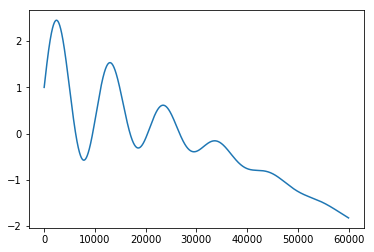

In [27]:
plt.plot(t_,y)
plt.plot(t_mid_log, y_est)

In [ ]:
plt.plot(t_,ydot)
plt.plot(t_mid_log, d_est)

In [ ]:
plt.plot(t_,ydotdot)
plt.plot(t_mid_log, dd_est)